In [1]:
import sys
sys.path.append('../src/')

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from unet import eval_preds

from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *

from data_utils import *
from models import *
from learn_utils import *

from pathlib import Path
from torch import FloatTensor as FT

import plotly.express as px
from ipywidgets import FloatSlider, interactive

from scipy.ndimage import label

#torch.cuda.set_device(6)

#  define image paths

In [3]:
# Read images
data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_2mets")
trn_img = sorted(list(Path(data_path/"training/skull_stripped_1x1x3").iterdir()))
trn_mask = sorted(list(Path(data_path/"training/mets_masks_1x1x3").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/skull_stripped_1x1x3").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/mets_masks_1x1x3").iterdir()))
test_img = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
test_mask = sorted(list(Path(data_path/"testing/mets_masks_1x1x3").iterdir()))


print(f"Size of Train Dataset Images: {len(trn_img)} Images")
print(f"Size of Validation Dataset Images: {len(valid_img)} Images")
print(f"Size of Train Dataset Masks: {len(trn_mask)} Images")
print(f"Size of Validation Dataset Masks: {len(valid_mask)} Images")
print(f"Size of Test 1 Dataset Images: {len(test_img)} Images")
print(f"Size of Test 1 Dataset Masks: {len(test_mask)} Images")

Size of Train Dataset Images: 113 Images
Size of Validation Dataset Images: 24 Images
Size of Train Dataset Masks: 113 Images
Size of Validation Dataset Masks: 24 Images
Size of Test 1 Dataset Images: 25 Images
Size of Test 1 Dataset Masks: 25 Images


In [4]:
class MR_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)

train_ds = MR_3D_Dataset(trn_img, trn_mask)
valid_ds = MR_3D_Dataset(valid_img, valid_mask)   
test_ds = MR_3D_Dataset(test_img, test_mask)

bs=1
data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=1)
test_dl = DeviceDataLoader(DataLoader(test_ds, batch_size=bs), device=data.device)

# load baseline 11 model (3D Residual UNet)

In [5]:
!ls ../model_training/ventricle/models

20191224_baseline_9.pth
20191224_mets_baseline_9.pth
best_of_20191231_Mets_first_tx_1met_simple_2.pth
best_of_20191231_Mets_first_tx_1met_simple.pth
best_of_20200101_first_tx_1met_simple_default.pth
best_of_20200102_first_tx_1met_simple_default.pth
best_of_20200113_first_tx_2mets_b9.pth
best_of_20200113_first_tx_3mets_b9.pth
best_of_20200118_first_tx_2mets_b9_2.pth
best_of_20200118_first_tx_2mets_b9.pth
best_of_20200122_first_tx_2mets_b9_2.pth
best_of_20200122_first_tx_2mets_b9_2x.pth
best_of_20200122_first_tx_2mets_b9.pth
best_of_20200124_first_tx_1met_b9.pth
best_of_20200124_first_tx_2mets_b9_2.pth
best_of_20200124_first_tx_2mets_b9.pth
best_of_20200125_first_tx_1met_b9_2.pth
best_of_20200125_first_tx_1met_b9.pth
best_of_20200126_first_tx_11+mets_b9_2.pth
best_of_20200126_first_tx_11+mets_b9.pth
best_of_20200126_first_tx_1met_b9_2.pth
best_of_20200126_first_tx_1met_b9.pth
best_of_20200126_first_tx_3mets_b9_2.pth
best_of_20200126_first_tx_3mets_b9.pth
best_of_20200126_first_tx_4-5mets

In [19]:
# Load model baseline11
model_name = 'baseline9'
f = experiment_model_dict[model_name]
m = f()

#m = VolumetricUnet(in_c=1, out_c=8, n_layers=4, c=1, block_type=conv_relu_bn_drop,
#                            norm_type='group', actn='prelu', p=0.)
    

loss_func = 'dice'
model_dir = '../model_training/ventricle/models/'
learn = Learner(data=data, model=m, callbacks=[], callback_fns=[], model_dir=model_dir)
learn.loss_func = {'dice':dice_loss, 'bce':BCEWithLogitsFlat(), 'mixed':None}[loss_func] 
learn.metrics = [dice_score]
learn.to_fp16();
learn.load('best_of_20200124_first_tx_2mets_b9'); # 2mets best model parameters
#learn.load('best_of_Mets_Baseline_9_first_tx_1met');


In [20]:
# get test1 predictions
learn.to_fp16();

# get test1 dice score and percent volume overlap

def get_preds_targs(dl):
    test_preds, test_targs = get_preds(learn.model, dl)
    test_preds.squeeze_(1); test_preds.sigmoid_();
    return test_preds, test_targs

#test_preds, test_targs = get_preds_targs(test_dl)
images, test_preds, test_masks = get_img_pred_masks(learn, test_dl)

#print(learn.validate(test_dl))

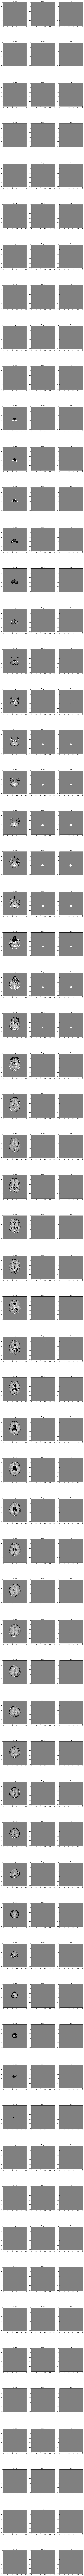

In [16]:
IMG_SET = 0
brainimgs = test_ds.__getitem__(IMG_SET)
plt.figure(figsize=(15, 500))
c = 1
for i in range(0,64):
    plt.subplot(64, 3, c)
    plt.imshow(brainimgs[0][0][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Image')
    c = c + 1
    plt.subplot(64, 3, c)
    plt.imshow(test_masks[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Target')
    c = c + 1
    plt.subplot(64, 3, c)
    plt.imshow(test_preds[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Pred')
    c = c + 1   

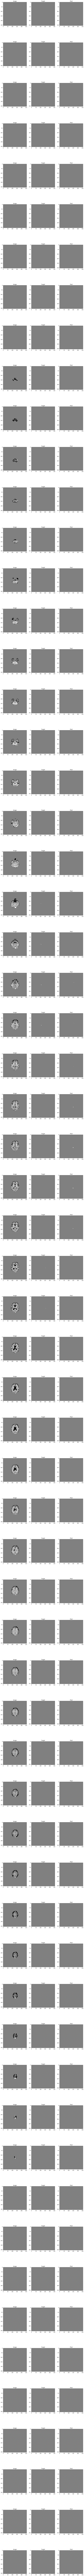

In [16]:
IMG_SET = 15
brainimgs = test_ds.__getitem__(IMG_SET)
#fig, ax = plt.subplots(55,2,figsize=(20,20))
#fig.set_size_inches(15,150)
plt.figure(figsize=(15, 500))
c = 1
for i in range(0,64):
    plt.subplot(64, 3, c)
    plt.imshow(brainimgs[0][0][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Image')
    c = c + 1
    plt.subplot(64, 3, c)
    plt.imshow(test_masks[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Target')
    c = c + 1
    plt.subplot(64, 3, c)
    plt.imshow(test_preds[IMG_SET][i,:,:], cmap="gray", vmin=-1, vmax=1)
    plt.title('Pred')
    c = c + 1

In [80]:
w = FloatSlider(value=32,min=0,max=63,step=1,description='Slice:')

def InteractiveReview(z):
    fig = px.imshow(t[int(z)], color_continuous_scale='gray', zmin=0, zmax=5)
    fig.update_layout(height=400, width=600)
    fig.show()

In [81]:
interactive(InteractiveReview, z=w)

interactive(children=(FloatSlider(value=32.0, description='Slice:', max=63.0, step=1.0), Output()), _dom_class…

# Generate table and figures, review testing set

In [8]:
def summary_table(target_masks, pred_masks, file_names):
    pred_dice_scores = [dice_score(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    pred_percent_vol_diff = [vol_perc_diff(target_masks[i], pred_masks[i], True)*100 for i in range(len(target_masks))]
    TPs = [true_positive(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    FPs = [false_positive(pred_masks[i], target_masks[i]) for i in range(len(target_masks))]
    target_mets = [label(target_masks[i]) for i in range(len(target_masks))]
    pred_mets = [label(pred_masks[i]) for i in range(len(target_masks))]
    target_num = [target_mets[i][1] for i in range(len(target_masks))] 
    pred_num = [pred_mets[i][1] for i in range(len(target_masks))] 
    d = {'test_name': file_names,
         'pred_dice_scores': pred_dice_scores, 
         'pred_percent_vol_diff': pred_percent_vol_diff,
         'target_mets': target_num,
         'pred_mets': pred_num,
         'true_positive': TPs,
         'false_positive': FPs}
    df = pd.DataFrame(data=d)
    return df

def met_volume(image,res):
    numMets = np.amax(image)# max number
    metNum, counts = np.unique(image.flatten(), return_counts=True)
    return np.asarray(counts[1:]*res)

def vol_perc_diff(mask, pred, absolute=False):
    #mask_vol = (((mask.numpy()).sum()).sum()).sum()
    #pred_vol = (((pred.numpy()).sum()).sum()).sum()
    mask_vol = ((mask.sum()).sum()).sum()
    pred_vol = ((pred.sum()).sum()).sum()
    if not absolute:
        return (pred_vol-mask_vol)/mask_vol
    return abs(pred_vol-mask_vol)/mask_vol

def dice_score(target, preds, thresh=0.5):
    iT = target#.numpy()
    iP = preds#.numpy()
    intersection = (((iT * iP).sum()).sum()).sum()
    return ((2.0 * intersection) / (((iT.sum()).sum()).sum() + ((iP.sum()).sum()).sum() + 1e-6))

# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
def true_positive(true_labels, pred_labels):
    TP = np.logical_and(pred_labels == 1., true_labels == 1.).sum().sum().sum()
    return TP

# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
def true_negative(true_labels, pred_labels):
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
    return TN

# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
def false_positive(true_labels, pred_labels):
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
    return FP


In [21]:
names = []
data_path = data_path = Path("/data/public/MIM_BMETS_V6/3_final_datasets/met_number_reviewed/first_tx_2mets")
test1_img_files = sorted(list(Path(data_path/"testing/skull_stripped_1x1x3").iterdir()))
ok_names = [o.name for o in test1_img_files]
file_names = [fn for fn in test1_img_files if fn.name in ok_names]
for i in range(len(file_names)):
    names.append(str(file_names[i]).split("/")[-1].split("_")[0])


df = summary_table(test_masks, test_preds, names)
df.describe()

,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,0.752734,35.185780,2.160000,1.840000,1764.560000,649.600000
std,0.277654,75.381214,0.472582,1.027943,1472.890019,1014.135182
min,0.000000,0.085470,2.000000,1.000000,0.000000,56.000000
25%,0.742841,5.042017,2.000000,1.000000,736.000000,103.000000
50%,0.841369,11.481481,2.000000,2.000000,1323.000000,269.000000
75%,0.910338,34.778729,2.000000,2.000000,2824.000000,765.000000
max,0.950597,379.310345,4.000000,5.000000,5404.000000,4739.000000


In [22]:
df[df['pred_dice_scores'] > 0.3].describe()

,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.849035,15.224468,2.181818,1.727273,2000.318182,675.227273
std,0.080776,14.815576,0.501081,0.935125,1411.990638,1059.929150
min,0.645509,0.085470,2.000000,1.000000,184.000000,56.000000
25%,0.815587,4.968369,2.000000,1.000000,841.250000,121.000000
50%,0.880909,8.947818,2.000000,2.000000,1382.500000,272.000000
75%,0.913440,23.653525,2.000000,2.000000,2866.000000,709.250000
max,0.950597,50.234384,4.000000,5.000000,5404.000000,4739.000000


In [23]:
pd.set_option('display.max_rows', df.shape[0]+1)
df

,test_name,pred_dice_scores,pred_percent_vol_diff,target_mets,pred_mets,true_positive,false_positive
0,BrainMets-UCSF-00012,0.917479,10.317731,2,1,2824,103
1,BrainMets-UCSF-00161,0.815217,4.706968,3,1,1725,442
2,BrainMets-UCSF-00195,0.139596,88.346686,2,3,107,1266
3,BrainMets-UCSF-00219,0.950597,0.639550,2,1,3704,205
4,BrainMets-UCSF-00224,0.890280,5.635607,2,2,5404,842
5,BrainMets-UCSF-00405,0.836626,16.734973,2,2,3367,1025
6,BrainMets-UCSF-00428,0.916379,5.042017,4,2,1063,127
7,BrainMets-UCSF-00466,0.871539,6.867329,2,2,2880,542
8,BrainMets-UCSF-00745,0.816695,25.663717,2,2,724,293
9,BrainMets-UCSF-00811,0.826966,17.622951,2,1,184,60
